# alibi detect のドリフト検出のデモ

以下の動画を参考にしている。

https://youtu.be/GCaznqhO1Hk?si=IyAfUiafj1embvad



## ドリフト検出の概要

### 10:15–12:50（スライド）で説明していることの全体像

この区間で説明しているのは、「参照データ（学習時など）と、いま入ってきたデータが“違って見える”とき、その違いは単なる偶然（サンプリングのゆらぎ）なのか、本当に分布が変わった（ドリフト）なのかを、統計的に判定する枠組み」です。スライドのタイトル “Sampling noise or drift?” がそのまま問いになっています。

---

### スライドの図が表しているもの（左＝Noise、右＝Drift）

#### 1) 何を比べているか
- 青緑の曲線や等高線が参照側の分布 $P(z_{\mathrm{ref}})$、赤が現在側の分布 $P(z)$ を表しています。
- 点は「分布から実際に観測したデータ（サンプル）」です。
- ここで $z$ は「監視したい値」を一般化した記号で、入力 $x$ でもよいし、モデルの中間表現（埋め込み）や出力でもよい、という意図です（動画でも「XでもYでもいいのでZと呼ぶ」という流れ）。

#### 2) 左のパネル（Noise）
- 見た目としては点の散らばり方や輪郭が少し違います。
- それでも $MMD^2=0.018$ と小さく、推定p値が $\hat{p}=0.8$ と大きいので、「この程度の違いは、同じ分布からたまたま別々にサンプルしただけでも起こり得る」と判断して Noise（ドリフトとは言わない）になっています。

#### 3) 右のパネル（Drift）
- 参照側と現在側のズレがより大きい状況です。
- $MMD^2=0.216$ と大きく、推定p値が $\hat{p}=0.02$ と小さいため、「同じ分布からたまたま出たとは考えにくい」と判断して Drift（ドリフト）になります。

この「$MMD^2$ はどちらも $0$ ではないのに、左はNoiseで右はDrift」という対比が、このスライドの核です。

---

### なぜ「距離（$MMD^2$）が0じゃない」だけではドリフトと言えないのか

現実には、分布 $P(z)$ そのものは見えません。見えるのは、その分布から取った有限個の観測値（サンプル）だけです。

同じ分布から2回サンプルしても、サンプル集合は一致しません。ヒストグラムや散布図は毎回少し違って見えます。これがサンプリングのゆらぎ（sampling noise）です。

だから、距離っぽい量（ここでは $MMD^2$）を計算して $0$ でなかったとしても、
- それが「本当に分布が変わったせい」なのか
- 「たまたま有限サンプルなのでズレて見えるだけ」なのか  
を分ける必要があります。

その“分け方”が、次の仮説検定とp値です。

---

### スライドの手順1：仮説（Hypotheses）を定義する

スライドに書かれている通りです。

帰無仮説（Null hypothesis）  
$H_0:\; P(z)=P(z_{\mathrm{ref}})$

対立仮説（Alternative hypothesis）  
$H_1:\; P(z)\neq P(z_{\mathrm{ref}})$

意味を日本語で言い換えるとこうです。

- $H_0$：いま見ているデータは、参照データと「同じルール（同じ分布）」から出ている。つまりドリフトは起きていない。
- $H_1$：いま見ているデータは、参照データとは「違うルール（違う分布）」から出ている。つまりドリフトが起きている。

---

### スライドの手順2：p値（p-value）を計算する

#### 1) まず「検定統計量（test statistic）」を作る：ここでは $MMD^2$
スライドでは距離の役として $MMD^2$ を使っています。MMD（最大平均差）は、ざっくり言うと「2つのデータ集合がどれくらい違う分布から来ていそうか」を1つの数で表す方法です。

形だけ示すと、分布 $P$ と $Q$（ここでは $P(z)$ と $P(z_{\mathrm{ref}})$）に対して

$MMD^2(P,Q)=\mathbb{E}[k(x,x')]+\mathbb{E}[k(y,y')]-2\mathbb{E}[k(x,y)]$

ここで $k(\cdot,\cdot)$ は「2点がどれだけ似ているか」を返す関数（カーネル）で、代表例はガウス型です。直感的には、
- 参照側の点どうしは互いに似ている（平均的に $k$ が大きい）
- 現在側の点どうしも互いに似ている
- でも参照側の点と現在側の点が似ていない  
となるほど、$MMD^2$ が大きくなります。

#### 2) p値の定義（スライドの式の意味）
スライド下段の式は次の内容です。

$\hat{p}=P(\text{観測した}MMD^2\text{と同じかそれ以上に極端な値}\mid H_0)$

言い換えると、

「もし本当にドリフトが無い（$H_0$ が正しい）と仮定したときに、今回観測された $MMD^2$ みたいな“でかいズレ”が、どれくらいの頻度で偶然起きるか」

がp値です。

重要な注意として、p値は「$H_0$ が正しい確率」ではありません。条件が逆です（「$H_0$ の下で観測以上が起きる確率」）。

---

### では $\hat{p}$ はどうやって出すのか（動画で言っていた「統計的に厳密」の中身）

多くのドリフト検知（Alibi Detectも含む）では、p値を置換検定（permutation test）で近似します。

考え方はシンプルです。

#### 1) $H_0$ が正しいなら「どっちのデータか」というラベルは意味を持たない
もし本当に $P(z)=P(z_{\mathrm{ref}})$ なら、2つの集合を混ぜてから「参照」「現在」という札を付け直しても、本質的には同じ状況のはずです（この性質を「入れ替えても同じ」と考えるのが置換検定の核です）。

#### 2) 具体的な計算手順
(1) 参照サンプルと現在サンプルを全部まとめて1つの集合にする。  
(2) ラベル（参照／現在）をランダムにシャッフルして、2群に分け直す。  
(3) その分け直しに対して $MMD^2$ を計算する。  
(4) これをたくさん繰り返して、「$H_0$ が正しいときに出る $MMD^2$ の分布（帰無分布）」を作る。  
(5) 観測された $T_{\mathrm{obs}}=MMD^2$ が、その帰無分布の中でどれだけ“上位（極端）”かを割合として数える。

推定p値を式で書くと（シャッフルを $B$ 回した場合）例えば

$\hat{p}=\dfrac{1+\sum_{b=1}^{B}\mathbf{1}[T_b\ge T_{\mathrm{obs}}]}{B+1}$

のように計算します（“0にならないように1を足す”流儀がよく使われます）。

スライドで $\hat{}$ が付いているのは、こうした反復（有限回のシャッフル）による推定値だからです。

---

### 判定規則：$\hat{p}<\alpha$ なら drift

スライド右下の結論がこれです。

$\hat{p}<\alpha\;\Rightarrow\;\text{drift}$

ここで $\alpha$ は「どれくらい厳しく“ドリフト”と言うか」を決めるしきい値（有意水準）です。動画では「$\alpha$ は誤検知率（偽陽性率）をコントロールできる」と説明していました。

意味を正確に言うと、

- $\alpha=0.05$ にすると、本当にドリフトが無い状況（$H_0$ が真）でも、約5%の確率で誤って drift と判定してしまう、という設計になる（長期的な頻度として）。

---

### スライドの2例を、この枠組みで“言葉だけ”で説明できるようにする

#### 左（Noise）の説明
(1) $MMD^2$ は $0.018$。完全一致ではないが小さい。  
(2) $H_0$（同じ分布）を仮定して置換検定をすると、これくらいの $MMD^2$ はよく出る。  
(3) その結果 $\hat{p}=0.8$。つまり「$H_0$ の下で、観測以上に極端な値が出る確率が80%もある」。  
(4) よって「たまたまのゆらぎで説明できる」ので drift とは言わない。

#### 右（Drift）の説明
(1) $MMD^2$ は $0.216$。左よりずっと大きい。  
(2) $H_0$ を仮定して置換検定をすると、ここまで大きい値はめったに出ない。  
(3) その結果 $\hat{p}=0.02$。つまり「$H_0$ の下で観測以上が出る確率が2%しかない」。  
(4) もし $\alpha=0.05$ なら $\hat{p}<\alpha$ なので $H_0$ を棄却し、drift と判定する。

この説明が自分の口でできれば、このスライドは“他人に教えられるレベル”で理解できています。

---

### ここまで理解した上で、誤解しやすいポイント（補足）

#### 1) drift判定＝モデル精度が落ちた、ではない
ドリフト検知は「データ分布が参照と変わった可能性」を統計的に言っているだけです。精度が必ず落ちるとは限りませんが、動画で言っていたように「精度低下の典型原因なので早期警報として重要」という位置づけです。

#### 2) サンプル数が多いと“わずかな違い”でもp値が小さくなる
データが大量にあると、ほんの小さな違いでも統計的には検出できてしまい、p値が小さくなります。逆に少なすぎると見逃しやすい。これは「検出力」の問題で、実務では「どれくらいの違いを問題とみなすか」も併せて考えます（p値だけで重要度を決めない）。

#### 3) 時系列データでは「シャッフルしてよいか」に注意
置換検定は「入れ替えても同じ」と見なせることが前提です。時系列で強い相関がある場合、単純シャッフルが前提を壊すことがあります。その場合はブロック単位の入れ替え等を検討します（ここはデータの性質に依存します）。

---

### 参考文献（APA、URLなし）

Gretton, A., Borgwardt, K. M., Rasch, M. J., Schölkopf, B., & Smola, A. (2012). A kernel two-sample test. Journal of Machine Learning Research, 13(25), 723–773.

Biau, D. J., Jolles, B. M., & Porcher, R. (2009). P value and the theory of hypothesis testing. Journal of Bone and Joint Surgery. American Volume, 91(7), 1601–1603.

SciPy Developers. (n.d.). scipy.stats.permutation_test (documentation).

Phipson, B., & Smyth, G. K. (2010). Permutation P-values should never be zero: Calculating exact P-values when permutations are randomly drawn. Statistical Applications in Genetics and Molecular Biology, 9(1), Article 39.

Seldon. (n.d.). Alibi Detect documentation / repository.


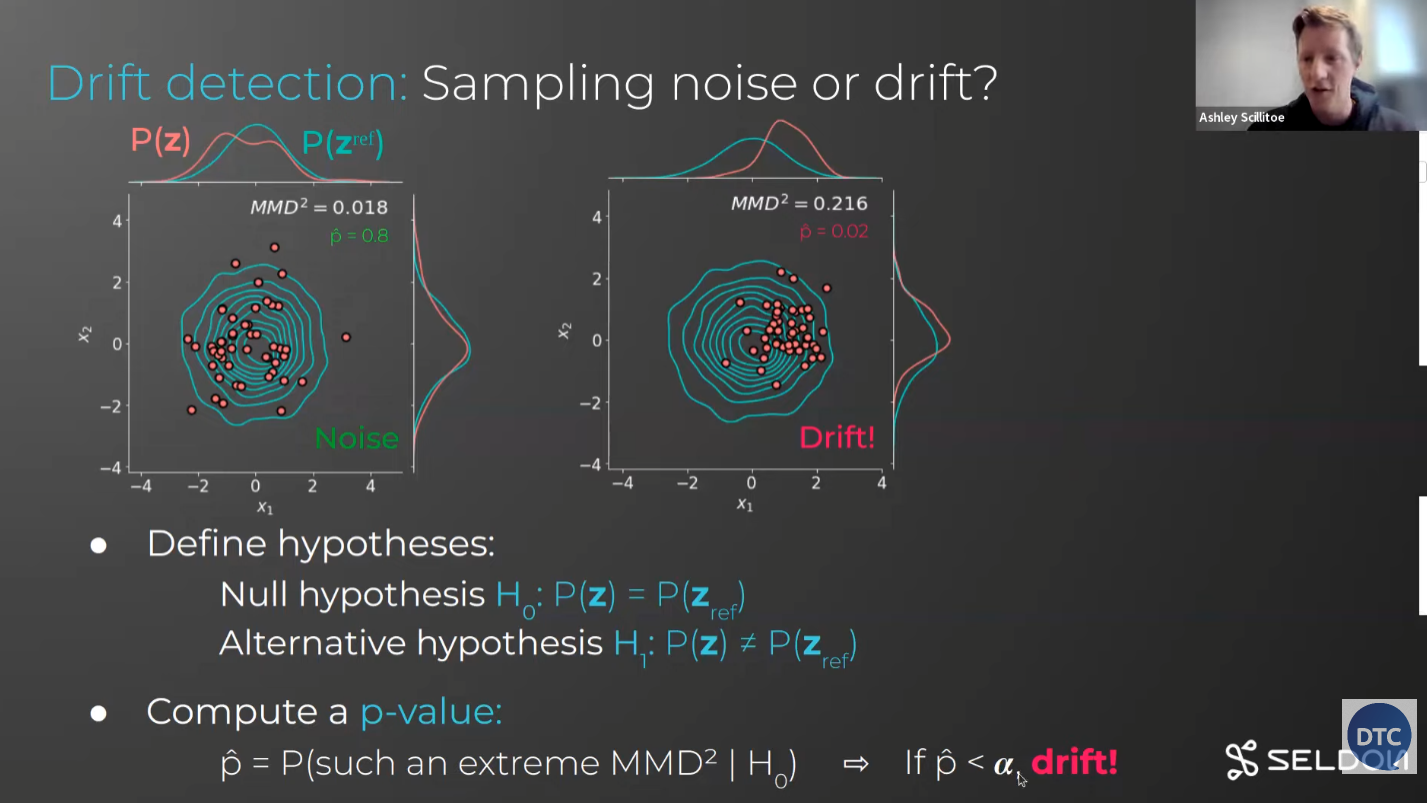

## A. サンプルコードの実行（単純な2次元データ）

In [1]:
import numpy as np
from alibi_detect.cd import KSDrift
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


### Matplotlib全体の「標準設定（デフォルト）」をまとめて変更するための辞書

In [2]:
params = {
    # 文字サイズの基本値（タイトル・軸ラベル・目盛り・凡例などに影響）
    "font.size": 17,

    # y軸の目盛り（目盛り線・目盛り文字）の色
    "ytick.color": "k",   # "k" = black（黒）

    # x軸の目盛り（目盛り線・目盛り文字）の色
    "xtick.color": "k",   # "k" = black（黒）

    # 軸ラベル（xlabel, ylabel）の文字色
    "axes.labelcolor": "k",

    # 軸の枠線（スパイン：上下左右の枠）の色
    "axes.edgecolor": "k"
}

# 上の辞書で指定した設定をMatplotlibの標準設定に一括反映
# これ以降に作る図は、特に指定しなくてもこの見た目がデフォルトになる
plt.rcParams.update(params)


### データプロット用の関数を定義

In [3]:
def plot_data(data1, data2):
    """
    2次元データ（列0=x1, 列1=x2）を「分布の形（kde）＋点（scatter）」で重ねて可視化する関数。

    設計意図（なぜこう書くか）
    - data1 を「参照分布（基準）」として、滑らかな分布形状（等高線＋周辺分布）で見せる。
    - data2 を「比較対象（テスト）」として、点群（散布図）と周辺分布（kde）を同じ図に重ねる。
    - こうすると「data2 が data1 に対してどこにズレたか（中心・広がり・形）」を直感的に確認できる。
    - jointplot を土台にすると、中央（2次元）＋上（x方向）＋右（y方向）の3領域を一括で作れるので、
      “2次元のズレ” と “各軸方向のズレ” を同時に見られる。

    前提
    - data1, data2 は shape=(N, 2) の配列（NumPy配列など）を想定。
      data[:,0] が x1、data[:,1] が x2。
    """

    # --- 1) 土台の作成：data1 を "参照分布" として描く -------------------------
    # sns.jointplot は JointGrid を返す：
    #   - fig.ax_joint   : 中央の2次元プロット領域
    #   - fig.ax_marg_x  : 上側のx方向周辺分布領域
    #   - fig.ax_marg_y  : 右側のy方向周辺分布領域
    #
    # kind="kde" により、中央は data1 の 2次元カーネル密度推定（等高線）になる。
    # height=6  : 図のサイズ（大きさ）の基準
    # ratio=4   : 中央領域（joint）が周辺領域（marginal）よりどれだけ大きいか
    # color     : data1 の分布の色
    # zorder=0  : 描画順序（小さいほど背面）→ 参照分布を背面に置き、あとから data2 を前面に重ねる
    fig = sns.jointplot(
        x=data1[:, 0], y=data1[:, 1],
        kind="kde",
        height=6,
        ratio=4,
        color="#0A009B",
        zorder=0
    )
    
    sns.scatterplot(
        x=data1[:, 0], y=data1[:, 1],
        color="#0A009B",
        s=40,
        edgecolor="w",
        linewidth=2,
        alpha=0.4,
        ax=fig.ax_joint,
        zorder=0
    )

    # 軸ラベル（LaTeX記法）を設定：この後に重ねる data2 も同じ軸で比較できるようにする
    fig.set_axis_labels(r"$x_1$", r"$x_2$")

    # --- 2) data2 を "比較対象" として中央の領域に散布図で重ねる -------------
    # sns.scatterplot を ax=fig.ax_joint に指定することで、
    # jointplot が作った中央領域の上に data2 の点を追加描画できる。
    #
    # s=70         : 点の大きさ
    # edgecolor='k': 点の縁取りを黒にして視認性を上げる（背景や等高線と区別しやすい）
    # linewidth=2  : 縁取り線の太さ
    # zorder=1     : data1（zorder=0）の上に表示されるよう前面に
    sns.scatterplot(
        x=data2[:, 0], y=data2[:, 1],
        color="#FF00D4",
        s=70,
        edgecolor="w",
        linewidth=2,
        ax=fig.ax_joint,
        zorder=1
    )

    # --- 3) data2 の周辺分布（1次元kde）を上・右の領域に重ねる --------------
    # data1 は jointplot(kind="kde") の設定により、
    # 中央だけでなく周辺領域にも data1 の分布が描かれている（実行環境/バージョンにより見え方差あり）。
    # ここで data2 の 1次元kde を重ねることで、各軸方向のズレを見比べやすくする。
    #
    # 上側（x方向の周辺分布）
    sns.kdeplot(
        x=data2[:, 0],
        ax=fig.ax_marg_x,
        color="#FF00D4"
    )

    # 右側（y方向の周辺分布）
    sns.kdeplot(
        y=data2[:, 1],
        ax=fig.ax_marg_y,
        color="#FF00D4"
    )

    # 注意：この関数は表示（描画）を目的としており、値は返さない設計にしている。
    # もし外側で追加編集（タイトル追加など）をしたいなら、最後に `return fig` として返す設計に変える。


### サンプルデータの作成

In [4]:
import numpy as np

# ============================================================
# 乱数の種（seed）を固定する
# ============================================================
# 設計意図:
# - 乱数でデータを作ると、実行するたびに結果が変わる（図やp値が毎回ブレる）。
# - seed を固定すると「毎回同じ乱数列」になり、再現性のあるデモになる。
# - 研究・検証・共有（他人の環境でも同じ結果）をしたいとき必須。
np.random.seed(0)

# ============================================================
# 1) 参照データ（Reference data）
# ============================================================
# 設計意図:
# - 「モデルを学習したときのデータ」または「正常とみなす基準データ」を想定。
# - この参照データの分布を P_ref と見なして、以降に来るデータが
#   そこからズレたか（ドリフトしたか）を検定する。
#
# 生成内容:
# - 2次元データ (x1, x2) を作る。
# - 平均 0、標準偏差 1 の正規分布 N(0,1) から独立にサンプル。
# - size=(500, 2) なので、サンプル数500、特徴量2。
#   つまり x_ref.shape は (500, 2) になり、列0が x1、列1が x2 を表す。
x_ref = np.random.normal(loc=0.0, scale=1.0, size=(500, 2))

# ============================================================
# 2) ドリフト無しのテストデータ（NO-DRIFT test data）
# ============================================================
# 設計意図:
# - 「参照と同じ分布から来ている」ケースを作って、
#   ドリフト検知器が誤って drift 判定しないこと（誤検知が少ないこと）を確認する。
#
# 生成内容:
# - 参照データと同じく N(0,1) から生成（平均0、標準偏差1）。
# - size=(50,2) なのでテストは少なめ（サンプル数50）。
#   実運用でも「監視ウィンドウ内のデータ数」は参照より小さいことが多いので、
#   その状況を模した設定。
x_h0 = np.random.normal(loc=0.0, scale=1.0, size=(50, 2))

# ============================================================
# 3) ドリフト有りのテストデータ（DRIFT test data）
# ============================================================
# 設計意図:
# - 「本当に分布が変わった」ケースを意図的に作り、
#   ドリフト検知器が drift 判定することを確認する。
#
# 生成内容:
# - np.random.normal は、loc と scale に配列を渡すと
#   「次元ごとに平均・標準偏差を変える」ことができる。
#
# - loc=[1.0, 0.0]
#   -> x1 の平均を 1.0 にシフト（参照の平均0からずらす）
#   -> x2 の平均は 0.0 のまま（参照と同じ）
#
# - scale=[0.6, 1.1]
#   -> x1 の標準偏差を 0.6（参照の1.0より小さくして広がりも変える）
#   -> x2 の標準偏差を 1.1（参照の1.0より少し大きくする）
#
# - size=(50,2) なのでサンプル数50、特徴量2。
#
# ここで起きている「ドリフト」の種類（直感）:
# - x1方向: 平均が変化（位置がずれる）＋広がりも変化
# - x2方向: 広がりが少し変化（分散が変わる）
#
# こうすることで、例えば KSDrift のように「特徴ごとにp値」を出す検知器では、
# どちらの次元が強く変わったかが p値として見えるようになる。
x_h1 = np.random.normal(loc=[1.0, 0.0], scale=[0.6, 1.1], size=(50, 2))


### サンプルデータの可視化

ドリフト有りのプロット点がずれている。2次元データの場合は差がわかりやすいが、画像やテキストや複数センサの高次元の場合は可視化できない。

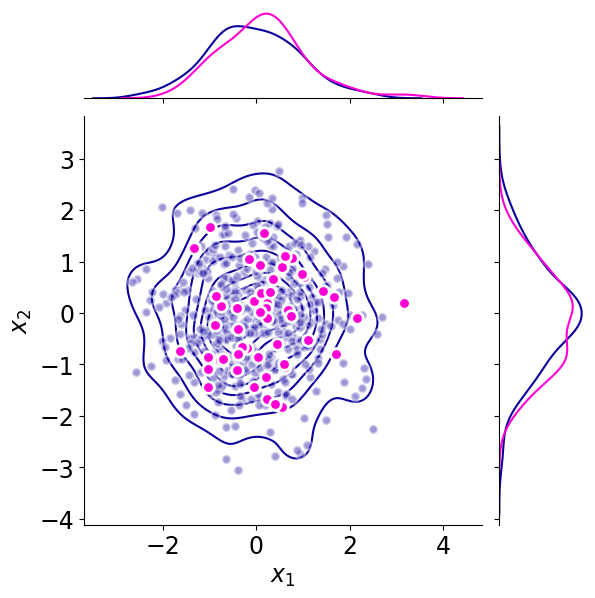

In [5]:
# ドリフト無しデータの分布を可視化
plot_data(x_ref, x_h0)


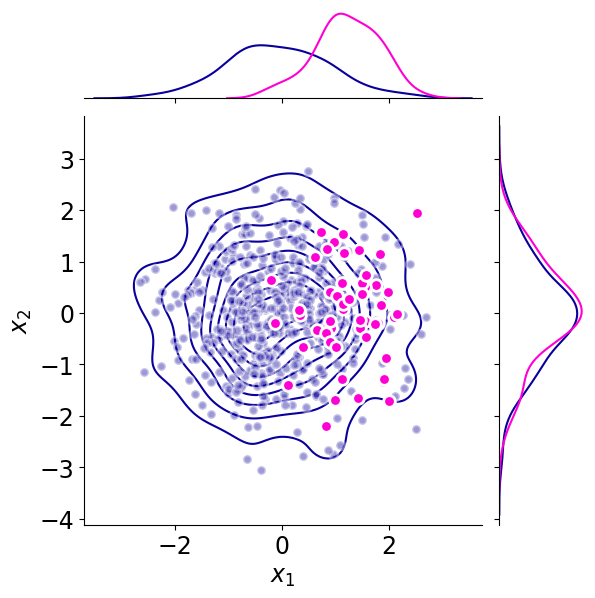

In [6]:
# ドリフト有りデータの分布を可視化
plot_data(x_ref, x_h1)

### KS 法による検出

「参照データ `x_ref` と比べて、テストデータ `x_h0` / `x_h1` が同じ分布から来ていると言えるか」を、`KSDrift` の `predict()` で判定し、返ってきた辞書の読み方まで説明している。

---

#### 1) ドリフト検知器を作る（参照データと判定基準を固定）

ここで起きていることは次の2つ。

(1) `x_ref` を「参照（基準）」として内部に保持する。  
以後 `dd.predict(X_test)` を呼ぶたびに「`X_test` と `x_ref` は同じ分布か？」を検定する。

(2) `p_val=0.05` を「ドリフト判定のしきい値（有意水準）」として設定する。  
各特徴（列）について得られる p 値を $p$ とすると、$p < 0.05$ なら「その特徴は参照と違う（ドリフトっぽい）」と判断する。

---



In [7]:
# 1) ドリフト検知器を作る
dd = KSDrift(x_ref, p_val=0.05)

#### 2) ドリフト無しのテストデータで `predict()`（期待どおり drift=0）

`predict()` は辞書を返す。最重要は `drift`（または `is_drift`）が 0/1 であること。

- `drift`（または `is_drift`）：0 ならドリフトなし、1 ならドリフトあり  
- `p_val`：特徴ごとの p 値（この例は2次元なので長さ2の配列）

この例の意味：
`x_h0` は `x_ref` と同じ分布から作った（平均も分散も同じ）ため、`p_val` が両方とも 0.05 より大きくなり、`drift=0` になる。  
「点の位置が少し違う」のは有限サンプルによるゆらぎ（Sampling noise）で説明できる、という結論。

---

In [8]:
# 2) ドリフト無し（同分布）のデータで判定
pred_h0 = dd.predict(x_h0)
pred_h0  # drift/is_drift と p_val を確認

{'data': {'is_drift': 0,
  'distance': array([0.154, 0.134], dtype=float32),
  'p_val': array([0.21304859, 0.36183926], dtype=float32),
  'threshold': 0.025},
 'meta': {'name': 'KSDrift',
  'online': False,
  'data_type': None,
  'version': '0.13.0',
  'detector_type': 'drift'}}


#### 3) ドリフト有りのテストデータで `predict()`（期待どおり drift=1）

`x_h1` は意図的に分布を変えて作っている（とくに第1列 $x_1$ をずらしている）。  
その結果、返ってくる `p_val` のうち **第1列に対応する p 値が 0.05 未満** になり、`drift=1` になる。

ここでのポイント：
`KSDrift` は単変量（各列ごと）の検知器なので、どの特徴（列）が怪しいかが p 値で分かる。  
この例では「$x_1$ にドリフトを入れた → $x_1$ の p 値が小さい」という整合が取れている。

---


In [9]:
# 3) ドリフト有り（分布変更）のデータで判定
pred_h1 = dd.predict(x_h1)
pred_h1  # drift/is_drift と p_val を確認

{'data': {'is_drift': 1,
  'distance': array([0.636, 0.108], dtype=float32),
  'p_val': array([3.3637637e-18, 6.3100189e-01], dtype=float32),
  'threshold': 0.025},
 'meta': {'name': 'KSDrift',
  'online': False,
  'data_type': None,
  'version': '0.13.0',
  'detector_type': 'drift'}}


#### 4) 返り値（辞書）を実務的に読むときの最小セット

Alibi Detect のバージョンによってキーの階層は少し変わるが、見るべき意味は同じ。

- まず全体の判定：`is_drift`（または `drift`）を見る  
- 次に場所の当たり：特徴ごとの `p_val` を見る

---

#### 重要ポイント（ここだけは外さない）

1. `predict()` は「統計的にドリフトと言えるか」を 0/1 で返す。  
2. `p_val=0.05` は「本当は同じ分布なのに誤ってドリフトと言う確率」を、理屈の上で 5% 程度に抑えるための設定。  
3. `KSDrift` は列ごとに p 値を返すので、ドリフトの“場所”（どの特徴が変わったか）が分かる。  
4. 同じ分布でも有限サンプルなので見た目はズレる。そのズレが「偶然の範囲か」を p 値で判断する。

---


## ~~B. サンプルコードの実行（複雑なデータ）~~

2026/01/25 時点：コードがエラーしてしまい実行不可

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from alibi_detect.models.tensorflow import scale_by_instance
from alibi_detect.utils.fetching import fetch_tf_model
from alibi_detect.saving import save_detector, load_detector
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c


### データの読み込み

最初はネットから保存。2回目以降はローカルフォルダを参照する。

In [11]:
# ============================================================
# CIFAR-10データセットを保存・前処理してNPZファイルに保存する
# ============================================================
'''
# CIFAR-10（学習用・評価用）をTensorFlow付属のデータセットから読み込む
# load_data() は (X_train, y_train), (X_test, y_test) を返す
# - X_train: 画像（学習用） 形は通常 (50000, 32, 32, 3)
# - y_train: ラベル（学習用）形は通常 (50000, 1)
# - X_test : 画像（評価用） 形は通常 (10000, 32, 32, 3)
# - y_test : ラベル（評価用）形は通常 (10000, 1)
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# 画像の型を float32 にし、画素値を 0〜1 に正規化する
# 元のCIFAR-10画像は多くの場合 uint8 で、画素値が 0〜255 の整数
# そのままだとニューラルネットの入力として扱いにくいので、
# float32 に変換して 255 で割り、0〜1 の範囲に揃える（計算が安定しやすい）
X_train = X_train.astype("float32") / 255
X_test  = X_test.astype("float32") / 255

# ラベルの型を int64 に統一し、形を (N, 1) → (N,) に潰す
# load_data() の y は通常 (N, 1) の「縦ベクトル」になっている
# reshape(-1,) は「要素数は同じまま1次元配列にする」という意味
# こうしておくと、インデックス参照・集計・比較（==）などが扱いやすい
y_train = y_train.astype("int64").reshape(-1,)
y_test  = y_test.astype("int64").reshape(-1,)
'''

'\n# CIFAR-10（学習用・評価用）をTensorFlow付属のデータセットから読み込む\n# load_data() は (X_train, y_train), (X_test, y_test) を返す\n# - X_train: 画像（学習用） 形は通常 (50000, 32, 32, 3)\n# - y_train: ラベル（学習用）形は通常 (50000, 1)\n# - X_test : 画像（評価用） 形は通常 (10000, 32, 32, 3)\n# - y_test : ラベル（評価用）形は通常 (10000, 1)\n(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()\n\n# 画像の型を float32 にし、画素値を 0〜1 に正規化する\n# 元のCIFAR-10画像は多くの場合 uint8 で、画素値が 0〜255 の整数\n# そのままだとニューラルネットの入力として扱いにくいので、\n# float32 に変換して 255 で割り、0〜1 の範囲に揃える（計算が安定しやすい）\nX_train = X_train.astype("float32") / 255\nX_test  = X_test.astype("float32") / 255\n\n# ラベルの型を int64 に統一し、形を (N, 1) → (N,) に潰す\n# load_data() の y は通常 (N, 1) の「縦ベクトル」になっている\n# reshape(-1,) は「要素数は同じまま1次元配列にする」という意味\n# こうしておくと、インデックス参照・集計・比較（==）などが扱いやすい\ny_train = y_train.astype("int64").reshape(-1,)\ny_test  = y_test.astype("int64").reshape(-1,)\n'

In [12]:
import os
import numpy as np

# # ==============================
# # 1) 任意の保存先パスを指定
# #    Windows例: r"C:\Users\あなた\Documents\data\cifar10_preprocessed.npz"
# #    mac/Linux例: "/Users/あなた/Documents/data/cifar10_preprocessed.npz"
# # ==============================
# save_path = r".\\data\\test_0_ドリフト検出の簡易デモ\\cifar10_preprocessed.npz"

# # ==============================
# # 2) フォルダが無ければ作る
# # ==============================
# os.makedirs(os.path.dirname(save_path), exist_ok=True)

# # ==============================
# # 3) npzで保存（圧縮あり）
# #    例：前処理済みの X_train, y_train, X_test, y_test を保存
# # ==============================
# np.savez_compressed(
#     save_path,
#     X_train=X_train,
#     y_train=y_train,
#     X_test=X_test,
#     y_test=y_test
# )

# print("Saved to:", save_path)


In [13]:
# ============================================================
# 2回目以降:保存したNPZファイルから前処理済みCIFAR-10データを読み込む
# ============================================================

import numpy as np

save_path = r".\\data\\test_0_ドリフト検出の簡易デモ\\cifar10_preprocessed.npz"

data = np.load(save_path)
X_train = data["X_train"]
y_train = data["y_train"]
X_test  = data["X_test"]
y_test  = data["y_test"]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


### データにノイズを加える
#### ノイズを加える方法の一覧の確認

In [14]:
# CIFAR-10-C で選べる「汚し方（corruption）」の名前一覧を取得して表示する
# CIFAR-10-C は CIFAR-10 に対して、ノイズ・ぼかし・明るさ変化などの劣化を人工的に加えたデータセット
# 各corruptionは severity（強さ）を 1〜5 の段階で持つ（5が最も強い）
corruptions = corruption_types_cifar10c()
print(corruptions)


['brightness', 'contrast', 'defocus_blur', 'elastic_transform', 'fog', 'frost', 'gaussian_blur', 'gaussian_noise', 'glass_blur', 'impulse_noise', 'jpeg_compression', 'motion_blur', 'pixelate', 'saturate', 'shot_noise', 'snow', 'spatter', 'speckle_noise', 'zoom_blur']


#### ノイズ方法の選択

In [15]:
# CIFAR-10-C で使う「劣化（corruption）の種類」を指定する
# 設計意図:
# - “現実の入力の変化”を人工的に作り、モデル性能低下とドリフト検知を再現するため。
# - ここでは代表的な4種類を選んでいる。
#   gaussian_noise : 画像全体にガウス雑音（ザラザラ）を加える
#   motion_blur    : 動きブレ（移動中の撮影のようなぼけ）を加える
#   brightness     : 明るさを変える（露出変化のような劣化）
#   pixelate       : 画素を粗くする（解像度低下のような劣化）
corruption = ['gaussian_noise', 'motion_blur', 'brightness', 'pixelate']

# CIFAR-10-C から「指定した劣化種類」の画像を取得する
# fetch_cifar10c の動き（要点）:
# - corruption=corruption で、上で選んだ複数種類の劣化データをまとめて取れる
# - severity=5 は劣化の強さ（1〜5）で、5が最も強い
# - return_X_y=True により、(画像, ラベル) を返す
#
# 返り値:
# - X_corr : 劣化画像の配列（shape は取得件数に依存。通常 (N, 32, 32, 3)）
# - y_corr : 対応する正解ラベル（shape は通常 (N,) か (N,1)）
X_corr, y_corr = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)

# 画素値のスケールを 0〜255 → 0〜1 に揃える
# 設計意図:
# - CIFAR-10-C は多くの場合 uint8（0〜255）で返ってくる
# - すでに通常の CIFAR-10 側を /255 しているので、比較やモデル入力の整合を取るために同じ前処理をする
X_corr = X_corr.astype('float32') / 255


### 学習/テストデータを選択してデータを作成する

In [16]:
# 乱数の種を固定（毎回同じ分割になるようにする）
np.random.seed(0)

# テスト画像の総数（CIFAR-10 の test は通常 10000）
n_test = X_test.shape[0]
print("Number of test samples:", n_test)

# 参照データ用のインデックスを「重複なし」でランダムに半分選ぶ
# size=n_test//2 : 半分の件数を選ぶ
# replace=False  : 同じ番号を重複して選ばない（サンプルを重ならせない）
idx = np.random.choice(n_test, size=n_test // 2, replace=False)

# 参照に選ばれなかった残り半分のインデックスを作る（＝NO-DRIFT 側）
# np.delete(np.arange(n_test), idx) は「全インデックスから idx を除外」する
idx_h0 = np.delete(np.arange(n_test), idx, axis=0)

# 参照データ（Reference）: 元のテストセットから idx で抽出
# 設計意図:
# - “基準分布”を作るために、汚れていない（元の）テストデータの半分を参照にする
X_ref, y_ref = X_test[idx], y_test[idx]

# NO-DRIFT テストデータ（H0側）: 残り半分（同じ元分布の別サンプル）
# 設計意図:
# - 同じ分布から来ているので、MMD/KSなどの検定で棄却されにくいはず（drift=0 を期待）
X_h0, y_h0 = X_test[idx_h0], y_test[idx_h0]

# 分割が意図どおりか確認（shape を出す）
print("Shapes of reference and NO-DRIFT data:")
print(X_ref.shape, X_h0.shape)


Number of test samples: 10000
Shapes of reference and NO-DRIFT data:
(5000, 32, 32, 3) (5000, 32, 32, 3)


### 参照側（y_ref）とNO-DRIFT側（y_h0）で、クラス分布が大きく偏っていないか（だいたい同じ比率か）を確認する

設計意図:
- ドリフト検知のデモでは「参照とテストは同じ分布」(H0) をまず作りたい。
- もし参照側とNO-DRIFT側でクラス比率が極端に違うと、画像自体の分布が変わったように見えてしまい、意図しない差が入る。
- そこで、各クラスの件数を数えて、参照側とNO-DRIFT側で“同じクラスが同じくらい含まれている” ことを軽くチェックする。
- CIFAR-10 の test は各クラスが 1000枚なので、半分に分けると各クラスは理想的には 500/500 に近いはず。このコードでは「参照 + NO-DRIFT の合計が各クラスで n_test//10（=1000）になっているか」を assert で保証している。


#### クラスとは何か（CIFAR-10の文脈）

CIFAR-10 は「画像分類」のデータセットで、各画像には **正解ラベル** が付いている。  
この正解ラベルの種類を **クラス（class）** と呼ぶ。

- CIFAR-10 はクラスが 10 種類ある
- その 10 種類を **番号 0〜9** に割り当てている
- `y_ref` や `y_h0` に入っている 0〜9 は **クラス番号（正解ラベルの番号）**

代表的な対応は次の通り。

0: airplane（飛行機）  
1: automobile（自動車）  
2: bird（鳥）  
3: cat（猫）  
4: deer（鹿）  
5: dog（犬）  
6: frog（カエル）  
7: horse（馬）  
8: ship（船）  
9: truck（トラック）  

---

#### `np.unique(..., return_counts=True)` がやっていること

`np.unique(y_ref, return_counts=True)` は次を返す。

- `classes`：`y_ref` に登場するクラス番号（例：0〜9）
- `counts_ref`：参照データ（`y_ref`）における各クラスの件数

同様に `counts_h0` は NO-DRIFT 側（`y_h0`）の各クラス件数。

つまりこのコードは「参照側にクラス0が何枚、クラス1が何枚…」を数えている。

---

#### なぜこのチェックが必要か（設計意図）

今回のデモでは `X_test` をランダムに半分ずつに分けて

- `X_ref`（参照）
- `X_h0`（NO-DRIFT：同じ分布のはず）

を作っている。

もし分割が偏ると、例えば「参照側に犬が多い」「NO-DRIFT側に飛行機が多い」などになり、  
本当は同じ分布なのに違って見える原因になる。  
そのため「クラス比率が大きくズレていないか」を確認している。

---

#### `assert cref + ch0 == n_test // 10` の意味

CIFAR-10 のテストセットは通常

- 全体：`n_test = 10000`
- クラス数：10
- 各クラスの枚数：`n_test // 10 = 1000`

テストセットを二分割して `y_ref` と `y_h0` を作っているので、各クラスについて

- 参照側の枚数（`cref`） + NO-DRIFT側の枚数（`ch0`） = 元の枚数（1000）

になっているはず。  
それが崩れていたら「分割ミス」「ラベル対応のズレ」などの可能性があるので早期に止める安全確認。


In [17]:
# classes      : y_ref に含まれるユニークなクラス番号の配列（例: 0〜9）
# counts_ref   : 参照側 y_ref における各クラスの件数
classes, counts_ref = np.unique(y_ref, return_counts=True)

# counts_h0    : NO-DRIFT側 y_h0 における各クラスの件数
# np.unique(..., return_counts=True) は (ユニーク値, 件数) を返すので [1] で件数だけ取り出す
counts_h0 = np.unique(y_h0, return_counts=True)[1]

# 参照側のクラス件数を表示する前置き
print('Class Ref H0')

# zip で 3つ（クラス番号, 参照側件数, NO-DRIFT側件数）を並行して取り出す
for cl, cref, ch0 in zip(classes, counts_ref, counts_h0):

    # 各クラスごとに、参照側 + NO-DRIFT側 = そのクラスの総数 になっているか確認
    # CIFAR-10 test の総数は n_test で、クラス数は10なので、各クラスの総数は n_test//10（通常 1000）
    # ここが崩れていると、分割ミスやラベル対応ズレなどの可能性があるので早期に止める。
    assert cref + ch0 == n_test // 10

    # クラス番号と、参照側/NO-DRIFT側の件数を表示して、偏りの程度を目視確認できるようにする
    print('{}    {} {}'.format(cl, cref, ch0))


Class Ref H0
0    472 528
1    510 490
2    498 502
3    492 508
4    501 499
5    495 505
6    493 507
7    501 499
8    516 484
9    522 478


### CIFAR-10-C（劣化データ）を、劣化種類ごとに分割してリスト化する

前提:
- すでに X_corr = fetch_cifar10c(...) で取得済み
- X_corr は「劣化種類を複数指定した場合」、種類ごとのブロックが連結された形で返ることがある（つまり [劣化1の全画像][劣化2の全画像]...[劣化Kの全画像] の順で並ぶ）

設計意図:
- 後段で「劣化種類ごとにドリフトを検知する」ため、1つの巨大配列のままだと扱いにくい。
- そこで、種類ごとに同じ長さ n_test の塊として切り出し、X_c[i] が i番目の劣化種類の画像群、という形に整理する。


In [18]:
# 劣化種類の数（例: 4種類なら 4）
n_corr = len(corruption)

# 劣化種類ごとに、長さ n_test のブロックを切り出してリストにする
# i * n_test : その劣化種類ブロックの開始位置
# (i+1)*n_test: 終了位置（Pythonのスライスは終端を含まない）
X_c = [X_corr[i * n_test:(i + 1) * n_test] for i in range(n_corr)]


### 元画像と劣化画像を同じインデックスで並べて目視比較（corruption確認）

目的:
- 1枚の「元画像（Original）」と、同じインデックスに対応する
- 各 corruption（劣化）の画像を並べて目視確認する。

設計意図:
- ドリフト検知の前に「本当にこの corruption はこういう見た目になるのか」を確認する。
- 例として i 番目の画像を固定し、劣化種類ごとの違いだけを比較できるようにする。
- X_corr は「[劣化1の全画像][劣化2の全画像]...」の順で連結されている想定なので、n_test を使ってブロック位置をずらして同じ i を取り出す。

Number of test samples: 10000


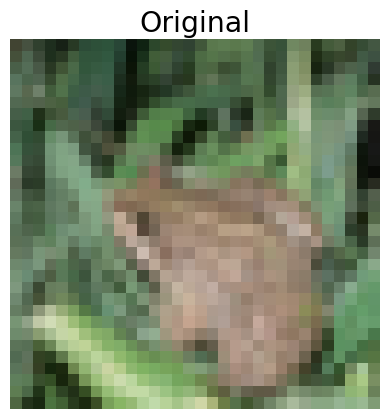

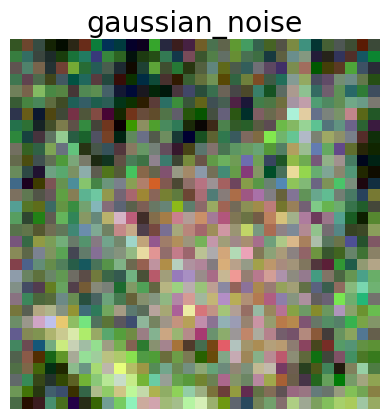

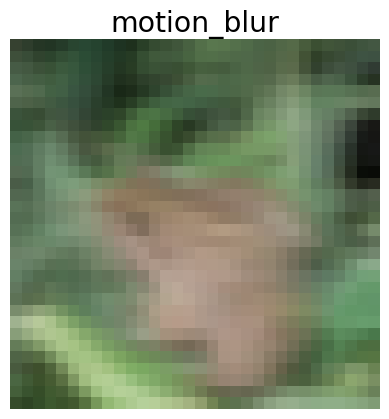

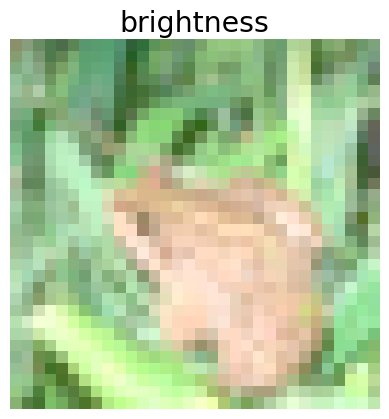

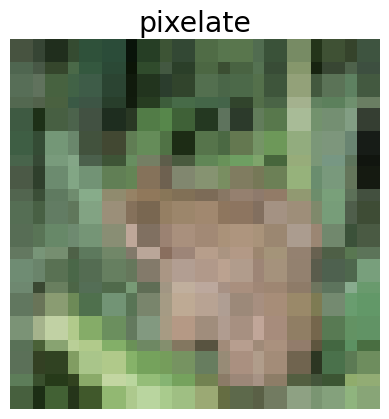

In [19]:

# 例として表示する画像のインデックス（何番目の画像を見るか）
i = 4

# 元のテストセットの枚数（CIFAR-10 test は通常 10000）
n_test = X_test.shape[0]
print("Number of test samples:", n_test)

# ----------------------------
# 1) 元画像（Original）の表示
# ----------------------------
plt.title("Original")     # 図のタイトル
plt.axis("off")           # 軸（目盛りや枠）を非表示（画像表示では邪魔なので消す）
plt.imshow(X_test[i])     # i番目の元画像を表示
plt.show()                # 描画を確定

# ----------------------------
# 2) 劣化画像（corruptionごと）を表示
# ----------------------------
# for _ in range(len(corruption)) の "_" は「使い捨てのループ変数」という意味
# corruption[_] で劣化種類名（例: 'gaussian_noise'）を取り出す
for _ in range(len(corruption)):
    plt.title(corruption[_])  # 現在表示している劣化種類名をタイトルにする
    plt.axis("off")

    # X_corr の並びが「劣化種類ごとに n_test 枚のブロック」で連結されている想定
    # 例: _=0 のとき [0*n_test ... 1*n_test-1] が劣化0の画像群
    #     _=1 のとき [1*n_test ... 2*n_test-1] が劣化1の画像群
    #
    # そこで「劣化 _ のブロックの中の i番目」は index = n_test * _ + i で取れる。
    plt.imshow(X_corr[n_test * _ + i])
    plt.show()


### 事前学習済みCIFAR-10分類器で、元画像と劣化画像の精度低下を比較評価

目的:
- CIFAR-10 用の既製（事前学習済み）画像分類モデルを読み込み、
- (1) 元のテストデータ（汚れていない）で精度を測る
- (2) 各 corruption（劣化）データで精度がどれだけ落ちるかを測る

設計意図:
- 「劣化が起きるとモデル性能が落ちる」ことを数値で示す（＝ドリフト検知の必要性の動機づけ）。
- 後段で“ドリフト検知器が drift を出す”ことと、“実際に精度が落ちる”ことを対応付けて理解できるようにする。


In [20]:
import os
from pathlib import Path

import numpy as np
import tensorflow as tf

from alibi_detect.models.tensorflow import scale_by_instance

# ============================================================
# Keras 3 対応: alibi_detect の fetch_tf_model が落ちる問題を回避する
# - tf.keras.utils.get_file の fname に「パス」が入ると Keras 3 で ValueError
# - fname はファイル名だけにし、保存先は cache_dir で指定する
# ============================================================
def fetch_tf_model_keras3_compatible(dataset: str, model: str, cache_dir: str):
    base_url = "https://storage.googleapis.com/seldon-models/alibi-detect/classifier/"
    origin = f"{base_url}{dataset}/{model}/model.h5"

    cache_dir = str(Path(cache_dir))
    os.makedirs(cache_dir, exist_ok=True)

    # fname は「ファイル名だけ」（パス禁止）
    fname = f"{model}.h5"

    local_path = tf.keras.utils.get_file(
        fname=fname,
        origin=origin,
        cache_dir=cache_dir,
        cache_subdir=""  # 余計なサブフォルダを作らない
    )

    # compile情報は信用せず compile=False で読み込み→自分でcompile
    clf = tf.keras.models.load_model(local_path, compile=False)

    # CIFAR-10 は 0〜9 の整数ラベル（sparse）なので sparse_categorical_crossentropy
    clf.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return clf, local_path


# ============================================================
# ここから「あなたのセル」を丸ごと置き換える版（すべて修正版）
# 前提: X_test, y_test, corruption, X_c がすでに作成済み
# ============================================================

# 使うデータセット名（モデルURLに使う識別子）
dataset = "cifar10"

# 使うモデル名（例：ResNet32）
model = "resnet32"

# 任意のローカル保存先（ここを好きな場所に）
# ※ Windows は raw文字列 r"..." 推奨
MODEL_CACHE_DIR = r".\\data\\test_0_ドリフト検出の簡易デモ\\.cache_alibi_models"

# 事前学習済みモデルを取得（初回のみDL、2回目以降はキャッシュ）
clf, model_path = fetch_tf_model_keras3_compatible(dataset, model, MODEL_CACHE_DIR)
print("Model cached at:", model_path)

# ------------------------------------------------------------
# 入力の整合チェック（事故防止）
# ------------------------------------------------------------
n_test = X_test.shape[0]
assert y_test.shape[0] == n_test, "y_test の長さが X_test と一致していません"
assert len(corruption) == len(X_c), "corruption と X_c の要素数が一致していません"
for name, Xk in zip(corruption, X_c):
    assert Xk.shape[0] == n_test, f"{name} の枚数が n_test と一致していません"

# ------------------------------------------------------------
# 1) 元のテストセット（X_test）で精度
# ------------------------------------------------------------
X_test_scaled = scale_by_instance(X_test)
acc = clf.evaluate(X_test_scaled, y_test, batch_size=128, verbose=0)[1]

print("Test set accuracy:")
print("Original {:.4f}".format(acc))

clf_accuracy = {"original": float(acc)}

# ------------------------------------------------------------
# 2) 各 corruption データで精度
# ------------------------------------------------------------
for name, Xk in zip(corruption, X_c):
    Xk_scaled = scale_by_instance(Xk)
    acc = clf.evaluate(Xk_scaled, y_test, batch_size=128, verbose=0)[1]
    clf_accuracy[name] = float(acc)
    print("{} {:.4f}".format(name, acc))

# clf_accuracy に結果が入る
# print(clf_accuracy)


ValueError: Unknown layer: 'TensorFlowOpLayer'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.